\newpage

# 0 Setup {-}

In [0]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [0]:
# importing tensorflow
try:
    import google.colab
    import tensorflow as tf
    %tensorflow_version 1.13
except:
    import tensorflow as tf
    assert tf.__version__ == "1.13.1"
    
    # ignore tensorflow depreciation warnings
    import tensorflow.python.util.deprecation as deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False

In [0]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [4]:
print(tf.__version__)

1.15.0


### 0.1 Visualizing the Dataset {-}

In [0]:
# given by the assignment
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data ["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

\newpage

In [6]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

FileNotFoundError: ignored

In [0]:
def plot(image, target, ax=None):
    ax = plt.gca() if ax == None else ax
    ax.imshow(image, cmap=plt.cm.gray)
    target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    ax.set_title(target_names[target])
    # targets interger encoded from 0 to 9 corresponding to 'A' to 'J', respectively

In [0]:
fig, axis = plt.subplots(2, 5, figsize=(16, 5))
for ax in axis.reshape(-1):
    r = np.random.randint(trainData.shape[0])
    plot(trainData[r], trainTarget[r], ax=ax)
plt.show()

\newpage

### 0.2 Useful Functions {-}

Some useful functions that will be used throughout the assignment such as getting random weights, getting the accuracy of a batch, making the loss and accuracy plots look nice, and global variables used throughout the code

In [0]:
# given by the assignment
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))
    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [0]:
def accuracy(y_pred, y):
    if y_pred.shape != y.shape:
        raise ValueError(f"prediction dimension {y_pred.shape} and label dimensions {y.shape} don't match")
    return np.sum(y_pred.argmax(axis=1) == y.argmax(axis=1)) / y.shape[0]

In [0]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")
    

def display_statistics(train_loss=None, train_acc=None, valid_loss=None, valid_acc=None, 
                       test_loss=None, test_acc=None, y_loss_min=0, y_acc_min=0):
    
    tl = "-" if train_loss is None else round(train_loss[-1], 4)
    ta = "-" if train_acc is None else round(train_acc[-1]*100, 2)
    vl = "-\t" if valid_loss is None else round(valid_loss[-1], 4)
    va = "-" if valid_acc is None else round(valid_acc[-1]*100, 2)
    sl = "-\t\t" if test_loss is None else round(test_loss[-1], 4)
    sa = "-" if test_acc is None else round(test_acc[-1]*100, 2)
    
    print(f"Training loss: {tl}{'':.20s}\t\tTraining acc: {ta}{'%' if ta != '-' else ''}")
    print(f"Validation loss: {vl}{'':.20s}\tValidation acc: {va}{'%' if va != '-' else ''}")
    print(f"Testing loss: {sl}{'':.20s}\tTesting acc: {sa}{'%' if sa != '-' else ''}")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

In [0]:
TINY = 1e-20
VTDatasets = {"validData" : validData, "validTarget" : validTarget,
              "testData" : testData, "testTarget" : testTarget}

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]
K = 10

\newpage

page 8
\newpage

page 9
\newpage

page 10
\newpage

page 11
\newpage

page 12
\newpage

page 13
\newpage

# 2 Neural Networks in Tensorflow {-}
## 2.1 Model implementation {-}

In [0]:
# load + reshape data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(15000,28,28,1)
validData = validData.reshape(1000,28,28,1)
testData = testData.reshape(2724,28,28,1)

# one-hot encode
train_labels, valid_labels, test_labels = convertOneHot(trainTarget, validTarget, testTarget)

In [0]:
# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# create model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28, 28,1)))    # input layer
model.add(layers.Conv2D(                                # conv layer
        filters=32,
        strides=(1,1),
        kernel_size=[3, 3],
        padding="same",
        activation='relu',
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
model.add(layers.BatchNormalization())                  # batch norm
model.add(layers.MaxPooling2D((2, 2)))                  # max pooling
model.add(layers.Flatten())                             # flatten
model.add(layers.Dense(784, activation='relu'))         # fully-connected 784
model.add(layers.Dense(10))                             # fully-connected 10
model.add(layers.Softmax())                             # softmax output

# compile model w/ Adam optimizer + cross entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


\newpage

## 2.2 Model Training {-}

In [ ]:
# callback to test after each epoch
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        # perform a test per epoch
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0, batch_size=32)
        self.test_loss.append(loss)
        self.test_acc.append(acc)
        # append to returned dictionary
        logs["test_loss"] = self.test_loss
        logs["test_acc"] = self.test_acc

Training loss: 1.4814		Training acc: 97.97%
Validation loss: 1.5248	Validation acc: 93.5%
Testing loss: 1.5293	Testing acc: 93.06%


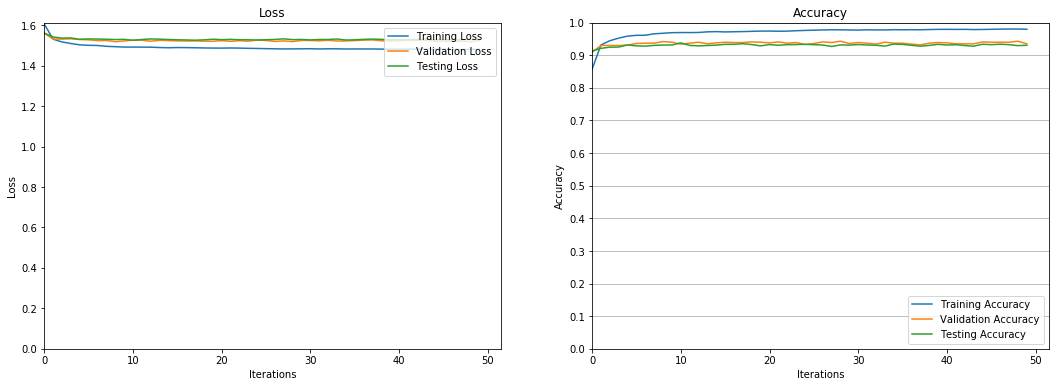

In [0]:
# training
history = model.fit(trainData, train_labels, 
                    validation_data = (validData, valid_labels),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[TestCallback((testData, test_labels))],
                    verbose=0,  # 0 = silent, 1 = per epoch 
                    shuffle=True)

# display statistics
train_acc, train_loss = history.history["acc"], history.history["loss"]
val_acc, val_loss = history.history["val_acc"], history.history["val_loss"]
test_acc, test_loss = history.history["test_acc"][0], history.history["test_loss"][0]

display_statistics(train_loss=train_loss, train_acc=train_acc, 
                   valid_loss=val_loss, valid_acc=val_acc,
                   test_loss=test_loss, test_acc=test_acc)

\newpage

## 2.3 Hyperparameter Investigation {-}

### 2.3.1 L2 Regularization {-}


L2 Normalization with 0.01

Training loss: 1.5349		Training acc: 96.81%
Validation loss: 1.5601	Validation acc: 94.2%
Testing loss: 1.5696	Testing acc: 93.43%


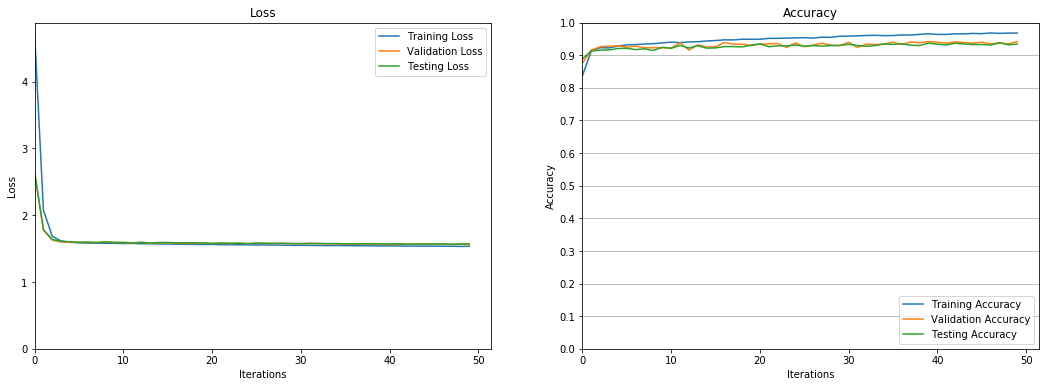


L2 Normalization with 0.1

Training loss: 1.6037		Training acc: 92.77%
Validation loss: 1.6033	Validation acc: 92.6%
Testing loss: 1.6058	Testing acc: 92.44%


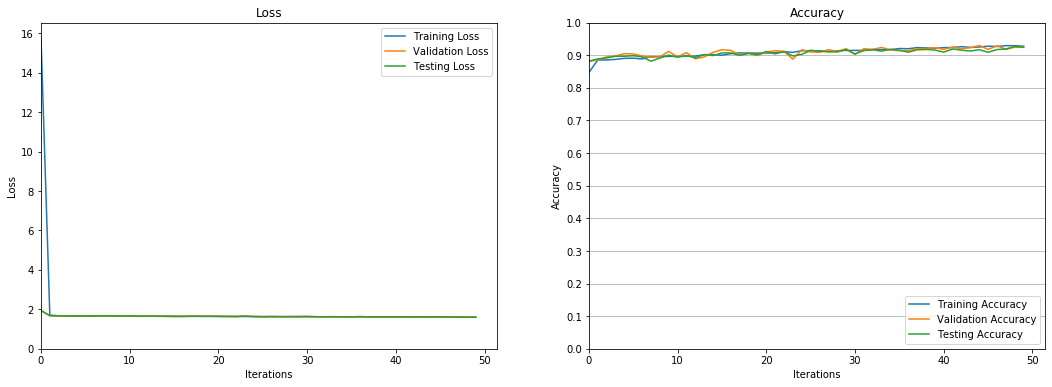


L2 Normalization with 0.5

Training loss: 1.6729		Training acc: 90.07%
Validation loss: 1.6705	Validation acc: 90.3%
Testing loss: 1.6746	Testing acc: 89.83%


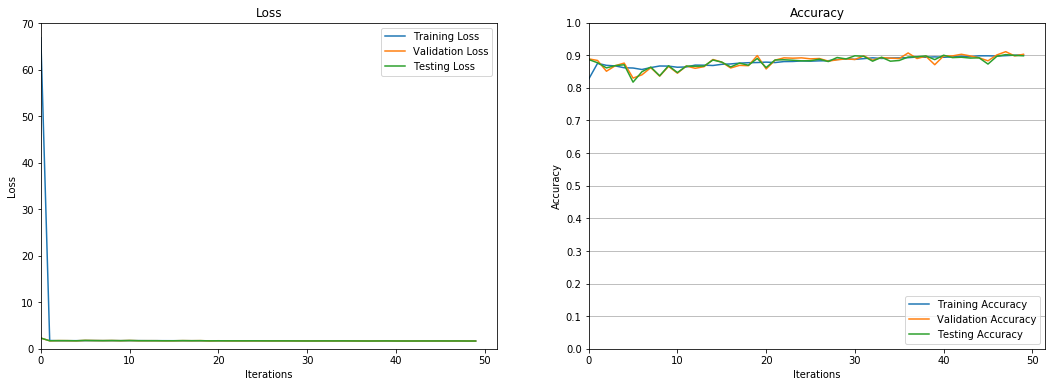

In [0]:
# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# test all weight decays [0.01, 0.1, 0.5]
for scale in [0.01, 0.1, 0.5]:
    print("\nL2 Normalization with {}\n".format(scale))

    # create model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(28, 28,1)))    # input layer
    model.add(layers.Conv2D(                                # conv layer
          filters=32,
          strides=(1,1),
          kernel_size=[3, 3],
          padding="same",
          activation='relu',
          kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
    model.add(layers.BatchNormalization())                  # batch norm
    model.add(layers.MaxPooling2D((2, 2)))                  # max pooling
    model.add(layers.Flatten())                             # flatten
    model.add(layers.Dense(784, 
                        activation='relu',
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=scale)))                                 # fully-connected 784 w/ ReLu
    model.add(layers.Dense(10))                             # fully-connected 10
    model.add(layers.Softmax())                             # softmax output

    # compile model w/ Adam optimizer + cross entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # train
    history_1 = model.fit(trainData, train_labels, 
                      validation_data = (validData, valid_labels),
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[TestCallback((testData, test_labels))],
                      verbose=0,  # 0 = silent, 1 = per epoch 
                      shuffle=True)
    # display statistics
    train_acc, train_loss = history.history["acc"], history.history["loss"]
    val_acc, val_loss = history.history["val_acc"], history.history["val_loss"]
    test_acc, test_loss = history.history["test_acc"][0], history.history["test_loss"][0]

    display_statistics(train_loss=train_loss, train_acc=train_acc, 
                       valid_loss=val_loss, valid_acc=val_acc,
                       test_loss=test_loss, test_acc=test_acc)

\newpage

### 2.3.2 Dropout {-}


Dropout with probability 0.1

Training loss: 1.4831		Training acc: 97.81%
Validation loss: 1.5229	Validation acc: 93.7%
Testing loss: 1.5219	Testing acc: 93.98%


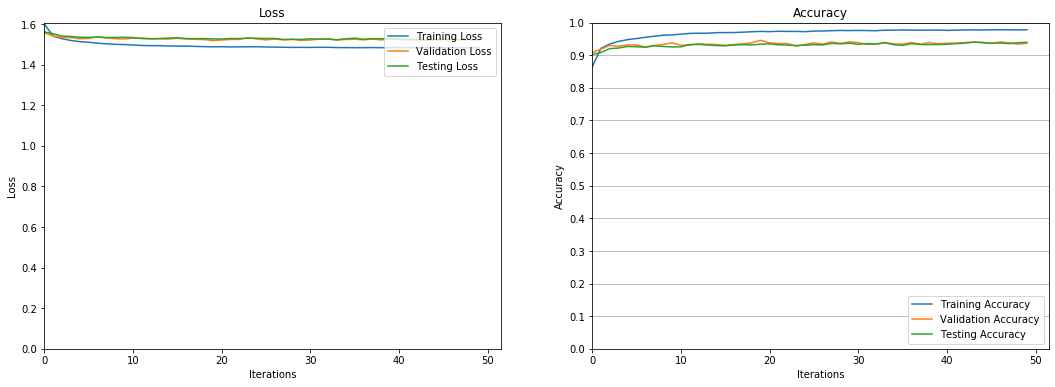


Dropout with probability 0.25

Training loss: 1.4794		Training acc: 98.19%
Validation loss: 1.5156	Validation acc: 94.4%
Testing loss: 1.527	Testing acc: 93.36%


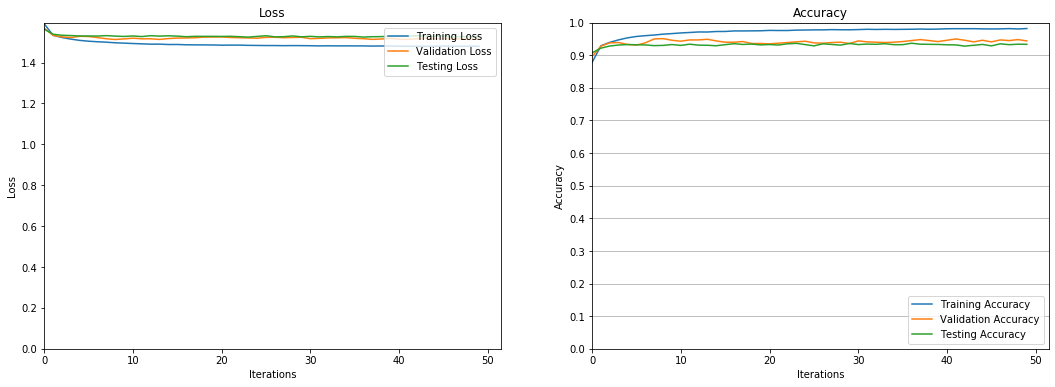


Dropout with probability 0.5

Training loss: 1.4803		Training acc: 98.09%
Validation loss: 1.5206	Validation acc: 94.0%
Testing loss: 1.5238	Testing acc: 93.69%


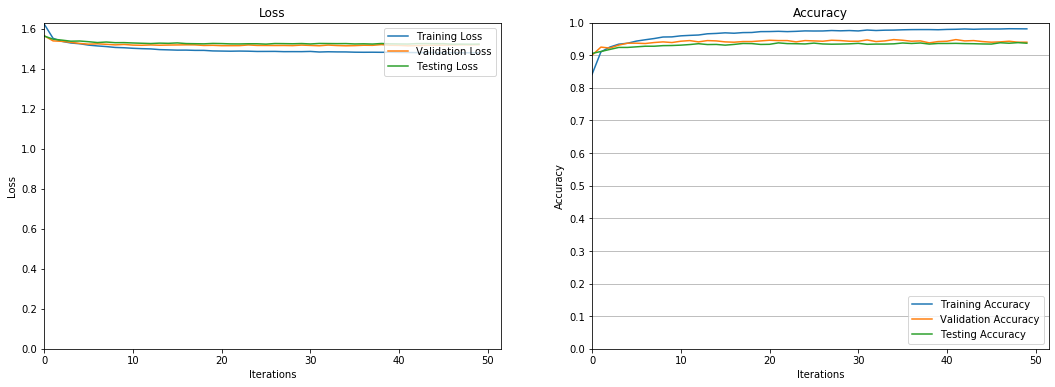

In [0]:
# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# for rate in [0.9, 0.75, 0.5]:
for rate in [0.1, 0.25, 0.5]:
    print("\nDropout with probability {}\n".format(rate))

    # create model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(28, 28,1)))   # input layer
    model.add(layers.Conv2D(                               # conv layer
          filters=32,
          strides=(1,1),
          kernel_size=[3, 3],
          padding="same",
          activation='relu',
          kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
    model.add(layers.BatchNormalization())                 # batch norm
    model.add(layers.MaxPooling2D((2, 2)))                 # max pooling
    model.add(layers.Flatten())                            # flatten
    model.add(layers.Dense(784))                           # fully-connected 784
    model.add(layers.Dropout(rate=rate))                   # dropout
    model.add(layers.ReLU())                               # Relu activation
    model.add(layers.Dense(10))                            # fully-connected 10
    model.add(layers.Softmax())                            # softmax output

    # compile model w/ Adam optimizer + cross entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # train
    history_2 = model.fit(trainData, train_labels, 
                      validation_data = (validData, valid_labels),
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[TestCallback((testData, test_labels))],
                      verbose=0,  # 0 = silent, 1 = per epoch 
                      shuffle=True)
    # display stats
    train_acc, train_loss = history.history["acc"], history.history["loss"]
    val_acc, val_loss = history.history["val_acc"], history.history["val_loss"]
    test_acc, test_loss = history.history["test_acc"][0], history.history["test_loss"][0]

    display_statistics(train_loss=train_loss, train_acc=train_acc, 
                       valid_loss=val_loss, valid_acc=val_acc,
                       test_loss=test_loss, test_acc=test_acc)

\newpage